In [1]:
import sys
sys.path.append('../')
sys.path.append('../DeepSurvivalMachines/')

In [2]:
import numpy as np

x = np.load('../ProcessedData/GeneCount.npy',allow_pickle=True)
t = np.load('../ProcessedData/TTE.npy',allow_pickle=True)
e = np.load('../ProcessedData/Event.npy',allow_pickle=True)

In [3]:
import torch
np.random.seed(42)
torch.random.manual_seed(42)

horizons = [0.75]
times = np.quantile(t[e!=0], horizons).tolist()

In [4]:
# Display the percentage of observed event at different time horizon
for time in times:
    print('At time {:.2f}'.format(time))
    for risk in np.unique(e):
        print('\t {:.2f} % observed risk {}'.format(100 * ((e == risk) & (t < time)).mean(), risk))

At time 7.23
	 64.92 % observed risk 0
	 13.87 % observed risk 1


In [5]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

x_train, x_test, t_train, t_test, e_train, e_test = train_test_split(x, t, e, test_size = 0.2, random_state = 42)
x_train, x_val, t_train, t_val, e_train, e_val = train_test_split(x_train, t_train, e_train, test_size = 0.2, random_state = 42)
x_dev, x_val, t_dev, t_val, e_dev, e_val = train_test_split(x_val, t_val, e_val, test_size = 0.5, random_state = 42)

minmax = lambda x: x / t_train.max() # Enforce to be inferior to 1
t_train_ddh = minmax(t_train)
t_dev_ddh = minmax(t_dev)
t_val_ddh = minmax(t_val)
times_ddh = minmax(np.array(times))

In [6]:
from sklearn.model_selection import ParameterSampler

In [7]:
layers = [[50], [50, 50], [50, 50, 50], [100], [100, 100], [100, 100, 100]]
param_grid = {
            'learning_rate' : [1e-3, 1e-4],
            'layers_surv': layers,
            'k': [2],
            'representation': [50, 100],
            'layers' : layers,
            'act': ['Tanh'],
            'batch': [100, 250],
            }
params = ParameterSampler(param_grid, 280 , random_state = 1)

In [8]:
from nsc import NeuralSurvivalCluster
import gc

In [9]:
gc.collect()
torch.cuda.empty_cache()

In [10]:
models = []
for param in params:
    model = NeuralSurvivalCluster(layers = param['layers'], act = param['act'], k = param['k'],
                                layers_surv = param['layers_surv'], representation = param['representation'])
    # The fit method is called to train the model
    model.fit(x_train, t_train_ddh, e_train, n_iter = 10, bs = param['batch'],
            lr = param['learning_rate'], val_data = (x_dev, t_dev_ddh, e_dev))
    nll = model.compute_nll(x_val, t_val_ddh, e_val)
    if not(np.isnan(nll)):
        models.append([nll, model])
    else:
        print("WARNING: Nan Value Observed")

Loss: 0.434: 100%|█████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  3.67it/s]


In [11]:
best_model = min(models, key = lambda x: x[0])
model = best_model[1]

In [12]:
out_risk = model.predict_risk(x_test, times_ddh.tolist())
out_survival= model.predict_survival(x_test, times_ddh.tolist())

In [13]:
from sksurv.metrics import concordance_index_ipcw, brier_score, cumulative_dynamic_auc

In [14]:
et_train = np.array([(e_train[i] == 1, t_train[i]) for i in range(len(e_train))],
                 dtype = [('e', bool), ('t', float)])
et_test = np.array([(e_test[i] == 1, t_test[i]) for i in range(len(e_test))],
                 dtype = [('e', bool), ('t', float)])
selection = (t_test < t_train.max()) | (e_test == 0)

cis = []
for i, _ in enumerate(times):
    cis.append(concordance_index_ipcw(et_train, et_test[selection], out_risk[:, i][selection], times[i])[0])
brs = brier_score(et_train, et_test[selection], out_survival[selection], times)[1]
roc_auc = []
for i, _ in enumerate(times):
    roc_auc.append(cumulative_dynamic_auc(et_train, et_test[selection], out_risk[:, i][selection], times[i])[0])
for horizon in enumerate(horizons):
    print(f"For {horizon[1]} quantile,")
    print("TD Concordance Index:", cis[horizon[0]])
    print("Brier Score:", brs[horizon[0]])
    print("ROC AUC ", roc_auc[horizon[0]][0], "\n")

For 0.75 quantile,
TD Concordance Index: 0.6097193333588429
Brier Score: 0.18212364985418117
ROC AUC  0.6089210716519302 



In [15]:
import pandas as pd
import matplotlib.pyplot as plt

In [16]:
times_cluster = np.quantile(t, np.linspace(0, 1, 100))
clusters = model.survival_cluster(minmax(times_cluster).tolist(), 1)

Text(0, 0.5, 'Survival Probability')

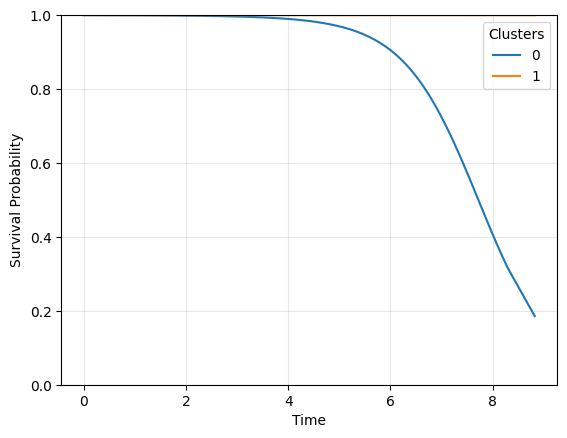

In [17]:
pd.DataFrame(clusters, index = times_cluster).plot()
plt.grid(alpha = 0.3)
plt.ylim(0, 1)
plt.legend(title = 'Clusters')
plt.xlabel('Time')
plt.ylabel('Survival Probability')

Text(0, 0.5, 'Survival Probability')

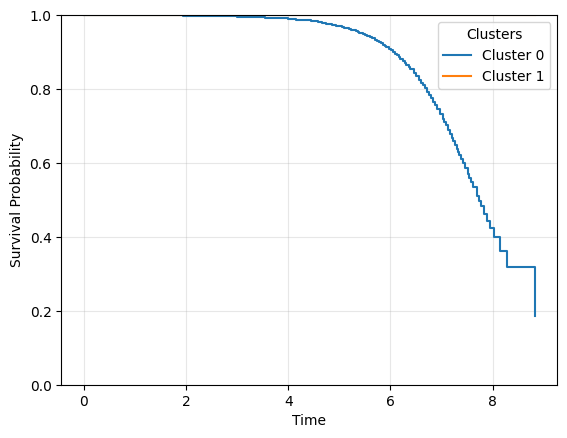

In [18]:

times_cluster = np.quantile(t, np.linspace(0, 1, 100))
clusters = model.survival_cluster(minmax(times_cluster).tolist(), 1)

fig, ax = plt.subplots()

for cluster in range(clusters.shape[1]):
    cluster_survival = clusters[:, cluster]
    step_times = np.repeat(times_cluster, 2)[1:]
    step_survival = np.repeat(cluster_survival, 2)[:-1]
    ax.plot(step_times, step_survival, label=f'Cluster {cluster}')

ax.grid(alpha=0.3)
ax.set_ylim(0, 1)
ax.legend(title='Clusters')
ax.set_xlabel('Time')
ax.set_ylabel('Survival Probability')
